In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_adbe = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/ADBE_Stock.csv"
df_adbe = pd.read_csv(csv_adbe, thousands=',')

In [3]:
df_adbe.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000
1,3/4/2019,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900
2,3/5/2019,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800
3,3/6/2019,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500
4,3/7/2019,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200


In [4]:
df_adbe.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,437.561171,437.561171,442.956797,431.746496,437.548852,2.987458e+06
std,112.802864,112.802864,113.786692,111.798628,112.881015,1.733830e+06
min,254.740005,254.740005,255.020004,249.100006,251.490005,5.892000e+05
25%,339.532501,339.532501,344.690010,333.492500,338.960007,2.039850e+06
50%,443.785004,443.785004,449.224991,436.915009,444.769989,2.573100e+06
75%,514.142502,514.142502,520.422485,508.869987,514.000000,3.413750e+06
max,688.369995,688.369995,699.539978,678.909973,696.280029,2.784020e+07


In [5]:
df_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_adbe['Date'] = df_adbe['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_adbe = df_adbe.sort_values(by="Date").reset_index(drop=True)
df_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_adbe.Close

0       264.010010
1       258.160004
2       257.380005
3       256.399994
4       255.460007
           ...    
1319    478.429993
1320    477.600006
1321    445.869995
1322    444.760010
1323    439.019989
Name: Close, Length: 1324, dtype: float64

In [8]:
df_adbe['Prev_close'] = df_adbe.shift(1)['Close']
df_adbe.Prev_close

0              NaN
1       264.010010
2       258.160004
3       257.380005
4       256.399994
           ...    
1319    475.429993
1320    478.429993
1321    477.600006
1322    445.869995
1323    444.760010
Name: Prev_close, Length: 1324, dtype: float64

In [9]:
df_adbe.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Prev_close
0,2019-03-01,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000,NaN
1,2019-03-04,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900,264.010010
2,2019-03-05,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800,258.160004
3,2019-03-06,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500,257.380005
4,2019-03-07,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200,256.399994


In [10]:
df_adbe['Close_change'] = df_adbe.progress_apply(
    lambda row: 0 if np.isnan(row.Prev_close) else row.Close - row.Prev_close,
    axis = 1
)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [11]:
df_adbe.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Prev_close,Close_change
0,2019-03-01,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000,NaN,0.000000
1,2019-03-04,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900,264.010010,-5.850006
2,2019-03-05,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800,258.160004,-0.779999
3,2019-03-06,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500,257.380005,-0.980011
4,2019-03-07,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200,256.399994,-0.939987


In [12]:
rows = []
for _,row in tqdm(df_adbe.iterrows(), total=df_adbe.shape[0]):
    row_data = dict(
        date = row.Date,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume,
        close_change = row.Close_change
    )
    rows.append(row_data)
features_adbe = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [13]:
features_adbe.head()

,date,open,low,high,close,volume,close_change
0,2019-03-01,265.750000,264.010010,266.239990,264.010010,2594000,0.000000
1,2019-03-04,266.700012,258.160004,267.000000,258.160004,2994900,-5.850006
2,2019-03-05,259.000000,257.380005,259.869995,257.380005,2101800,-0.779999
3,2019-03-06,257.399994,256.399994,259.489990,256.399994,1950500,-0.980011
4,2019-03-07,255.770004,255.460007,257.489990,255.460007,3185200,-0.939987


In [14]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [15]:
detect_outlier(features_adbe, 'close')

Empty DataFrame
Columns: [date, open, low, high, close, volume, close_change]
Index: []


In [16]:
detect_outlier(features_adbe, 'volume')

           date        open         low        high       close    volume   
10   2019-03-15  258.029999  257.089996  260.000000  257.089996  12110500  \
40   2019-04-29  286.459992  286.140015  291.709992  286.140015   5592400   
76   2019-06-19  287.000000  291.209992  292.000000  291.209992   9738600   
77   2019-06-20  293.250000  302.109985  302.660004  302.109985   5632500   
139  2019-09-18  275.350006  279.720001  280.290008  279.720001   7449700   
...         ...         ...         ...         ...         ...       ...   
1270 2024-03-18  495.549988  513.859985  515.729981  513.859985   7052700   
1271 2024-03-19  509.890015  521.190002  522.679993  521.190002   7081800   
1288 2024-04-12  477.950012  474.089996  478.779999  474.089996   5620000   
1321 2024-05-30  464.899994  445.869995  466.820007  445.869995   5606900   
1322 2024-05-31  447.720001  444.760010  448.230011  444.760010   7487500   

      close_change  
10      -10.600006  
40        4.180023  
76       14.

In [17]:
detect_outlier(features_adbe, 'close_change')

           date        open         low        high       close    volume   
257  2020-03-09  311.679993  305.790008  322.440002  305.790008   5291900  \
258  2020-03-10  318.980011  332.380005  332.940002  332.380005   5973700   
260  2020-03-12  290.410004  285.000000  310.130005  285.000000   7230200   
261  2020-03-13  312.880005  335.500000  336.000000  335.500000   8935200   
262  2020-03-16  288.359985  286.029999  307.109985  286.029999   7140100   
...         ...         ...         ...         ...         ...       ...   
1250 2024-02-16  589.900024  546.659973  590.140015  546.659973  10323000   
1261 2024-03-05  562.599976  544.840027  564.190002  544.840027   4286800   
1269 2024-03-15  499.640015  492.459992  503.130005  492.459992  19570500   
1270 2024-03-18  495.549988  513.859985  515.729981  513.859985   7052700   
1321 2024-05-30  464.899994  445.869995  466.820007  445.869995   5606900   

      close_change  
257     -30.979981  
258      26.589996  
260     -30.

In [18]:
features_adbe = features_adbe.set_index("date")
features_adbe.head()

,open,low,high,close,volume,close_change
date,,,,,,
2019-03-01,265.750000,264.010010,266.239990,264.010010,2594000,0.000000
2019-03-04,266.700012,258.160004,267.000000,258.160004,2994900,-5.850006
2019-03-05,259.000000,257.380005,259.869995,257.380005,2101800,-0.779999
2019-03-06,257.399994,256.399994,259.489990,256.399994,1950500,-0.980011
2019-03-07,255.770004,255.460007,257.489990,255.460007,3185200,-0.939987


In [19]:
train_size = int(0.7 * len(features_adbe))
test_size = len(features_adbe)-train_size

train_adbe_df = features_adbe[:train_size]
test_adbe_df = features_adbe[train_size:]

Text(0.5, 1.0, 'Time Series Plots of adbe stock')

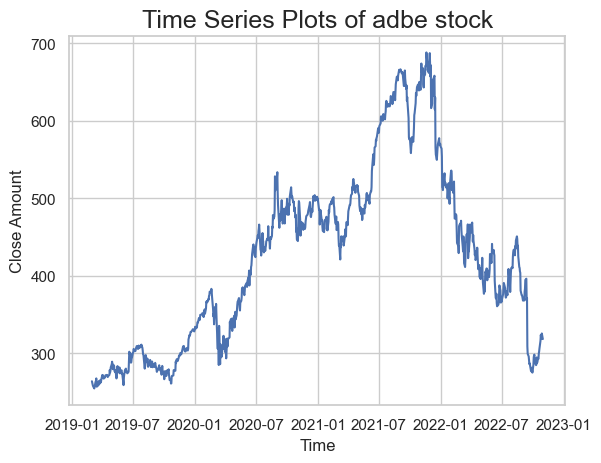

In [20]:
fig, ax = plt.subplots()
ax.plot(train_adbe_df.index, train_adbe_df['close'])
ax.set_ylabel('Close Amount')
ax.set_xlabel('Time')
ax.set_title('Time Series Plots of adbe stock', size=18)

The additive method is useful when the trend and seasonal variation is relatively constant over time as shown below whereas the multiplicative method is useful when the trend and seasonal variation increases or decreases in magnitude over time

Text(0.5, 0, 'Y')

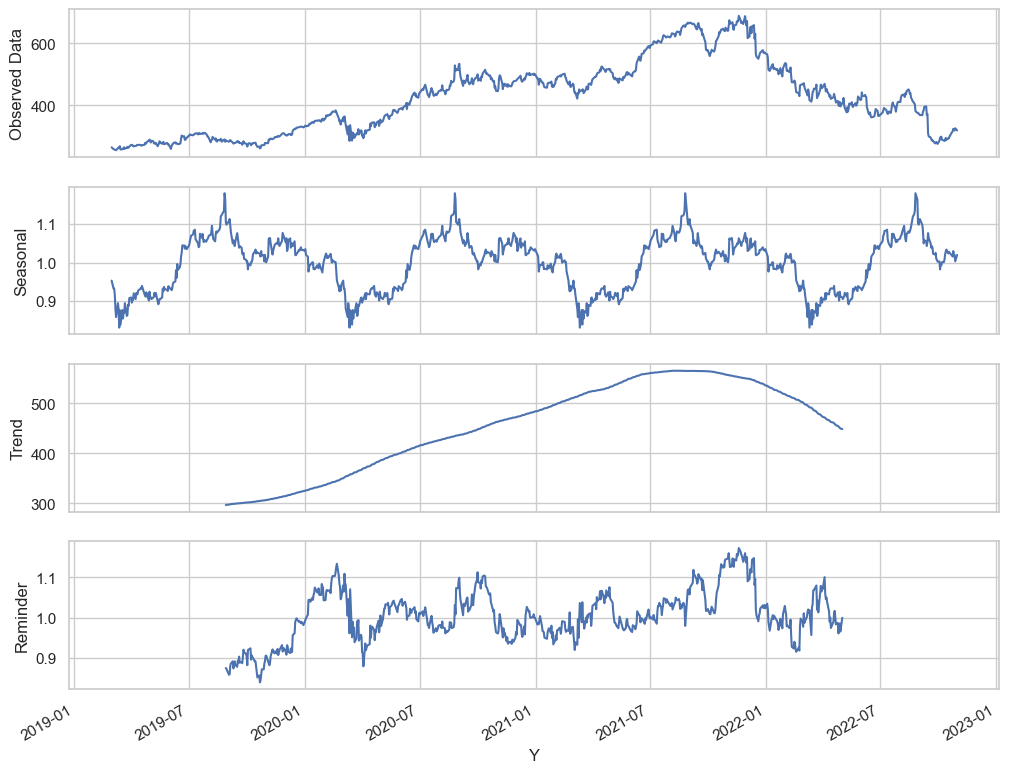

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train_adbe_df['close'], model='multiplicative', period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Y")

### Determine Error, Trend and Seasonality

An ETS model has three main components: error, trend, and seasonality. Each can be applied either additively, multiplicatively, or not at all. We will use the above Times Series Decomposition Plot to determine the additive or multiplicative property of the three components.

1. Trend - If the trend plot is linear then we apply it additively (A). If the trend line grows or shrinks exponentially, we apply it multiplicatively (M). If there is no clear trend, no trend component is included (N).

2. Seasonal - If the peaks and valleys for seasonality are constant over time, we apply it additively (A). If the size of the seasonal fluctuations tends to increase or decrease with the level of time series, we apply it multiplicatively (M). If there is no seasonality, it is not applied (N).

3. Error - If the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). If the error plot is fluctuating between large and small errors over time, we apply it multiplicatively (M).

There are 3 kinds of smoothing techniques Single, Double and Triple Exponential Smoothing. 
1. <b>Single Exponential Smoothing</b> is used when the time series does not have a trend line and a seasonality component.
2. <b>Double Exponential Smoothing</b> is used to include forecasting data with a trend, smoothing calculation includes one for the level, and one for the trend.
3. <b>Triple Exponential smoothing</b> is used when data has trend and seasonality. We include a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.

Since out data has both trend and seasonality components, we will apply Triple Exponential Smoothing.

In [22]:
# Import the relevant libraries 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
#Quá trình training
train_adbe_df1 = pd.Series(train_adbe_df['close']).astype('float64')
ets_model = ETSModel(train_adbe_df1, error='mul', trend='add', seasonal = 'add', 
                     damped_trend=True, seasonal_periods=5, initial_level=train_adbe_df.values.mean())
ets_fitted = ets_model.fit()
print(ets_fitted.summary())

C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 ETS Results                                  
Dep. Variable:                  close   No. Observations:                  926
Model:                      ETS(MAdA)   Log Likelihood               -3413.040
Date:                Mon, 17 Jun 2024   AIC                           6850.081
Time:                        23:23:30   BIC                           6908.051
Sample:                             0   HQIC                          6872.196
                                - 926   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.8319      0.014     58.720      0.000       0.804       0.860
smoothing_trend        0.0129        nan        nan        nan         nan         nan
smoothing_seasonal  

In [23]:
# Quá trình testing
# Forecast the values for the test set
test_predictions = ets_fitted.predict(start=len(train_adbe_df), end=len(train_adbe_df) + len(test_adbe_df) - 1 )
test_dates = pd.date_range(start=test_adbe_df.index[0], periods=len(test_predictions))
test_predictions.index = test_dates
# Output the forecasted values for the test set
print("Test Set Predictions:")
print(test_predictions)

Test Set Predictions:
2022-11-01    320.422121
2022-11-02    320.120235
2022-11-03    319.969377
2022-11-04    319.785294
2022-11-05    319.799736
                 ...    
2023-11-29    319.942151
2023-11-30    319.925222
2023-12-01    320.728483
2023-12-02    320.365324
2023-12-03    320.165448
Freq: D, Length: 398, dtype: float64


C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
#Predict the closing prices for the next 30 days
forecast_horizon = 30
forecast_dates = pd.date_range(start=features_adbe.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_30_days = ets_fitted.predict(start=len(features_adbe), end=len(features_adbe) + forecast_horizon - 1)
forecast_30_days.index = forecast_dates
print(forecast_30_days)

2024-06-04    319.942151
2024-06-05    319.925222
2024-06-06    320.728483
2024-06-07    320.365324
2024-06-08    320.165448
2024-06-09    319.942151
2024-06-10    319.925222
2024-06-11    320.728483
2024-06-12    320.365324
2024-06-13    320.165448
2024-06-14    319.942151
2024-06-15    319.925222
2024-06-16    320.728483
2024-06-17    320.365324
2024-06-18    320.165448
2024-06-19    319.942151
2024-06-20    319.925222
2024-06-21    320.728483
2024-06-22    320.365324
2024-06-23    320.165448
2024-06-24    319.942151
2024-06-25    319.925222
2024-06-26    320.728483
2024-06-27    320.365324
2024-06-28    320.165448
2024-06-29    319.942151
2024-06-30    319.925222
2024-07-01    320.728483
2024-07-02    320.365324
2024-07-03    320.165448
Freq: D, dtype: float64


C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [25]:
#Predict the closing prices for the next 60 days
forecast_horizon = 60
forecast_dates = pd.date_range(start=features_adbe.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_60_days = ets_fitted.predict(start=len(features_adbe), end=len(features_adbe) + forecast_horizon - 1)
forecast_60_days.index = forecast_dates
print(forecast_60_days)

2024-06-04    319.942151
2024-06-05    319.925222
2024-06-06    320.728483
2024-06-07    320.365324
2024-06-08    320.165448
2024-06-09    319.942151
2024-06-10    319.925222
2024-06-11    320.728483
2024-06-12    320.365324
2024-06-13    320.165448
2024-06-14    319.942151
2024-06-15    319.925222
2024-06-16    320.728483
2024-06-17    320.365324
2024-06-18    320.165448
2024-06-19    319.942151
2024-06-20    319.925222
2024-06-21    320.728483
2024-06-22    320.365324
2024-06-23    320.165448
2024-06-24    319.942151
2024-06-25    319.925222
2024-06-26    320.728483
2024-06-27    320.365324
2024-06-28    320.165448
2024-06-29    319.942151
2024-06-30    319.925222
2024-07-01    320.728483
2024-07-02    320.365324
2024-07-03    320.165448
2024-07-04    319.942151
2024-07-05    319.925222
2024-07-06    320.728483
2024-07-07    320.365324
2024-07-08    320.165448
2024-07-09    319.942151
2024-07-10    319.925222
2024-07-11    320.728483
2024-07-12    320.365324
2024-07-13    320.165448


C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [26]:
#Predict the closing prices for the next 90 days
forecast_horizon = 90
forecast_dates = pd.date_range(start=features_adbe.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_90_days = ets_fitted.predict(start=len(features_adbe), end=len(features_adbe) + forecast_horizon - 1)
forecast_90_days.index = forecast_dates
print(forecast_90_days)

2024-06-04    319.942151
2024-06-05    319.925222
2024-06-06    320.728483
2024-06-07    320.365324
2024-06-08    320.165448
                 ...    
2024-08-28    319.942151
2024-08-29    319.925222
2024-08-30    320.728483
2024-08-31    320.365324
2024-09-01    320.165448
Freq: D, Length: 90, dtype: float64


C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
ets_model_no_damped = ETSModel(train_adbe_df1, error='mul', trend='add', seasonal = 'add', 
                      seasonal_periods=5, initial_level=train_adbe_df.values.mean())
ets_fitted_no_damped = ets_model.fit()
print(ets_fitted_no_damped.summary())

C:\Users\FPT-ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 ETS Results                                  
Dep. Variable:                  close   No. Observations:                  926
Model:                      ETS(MAdA)   Log Likelihood               -3413.040
Date:                Mon, 17 Jun 2024   AIC                           6850.081
Time:                        23:23:30   BIC                           6908.051
Sample:                             0   HQIC                          6872.196
                                - 926   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.8319      0.014     58.720      0.000       0.804       0.860
smoothing_trend        0.0129        nan        nan        nan         nan         nan
smoothing_seasonal  

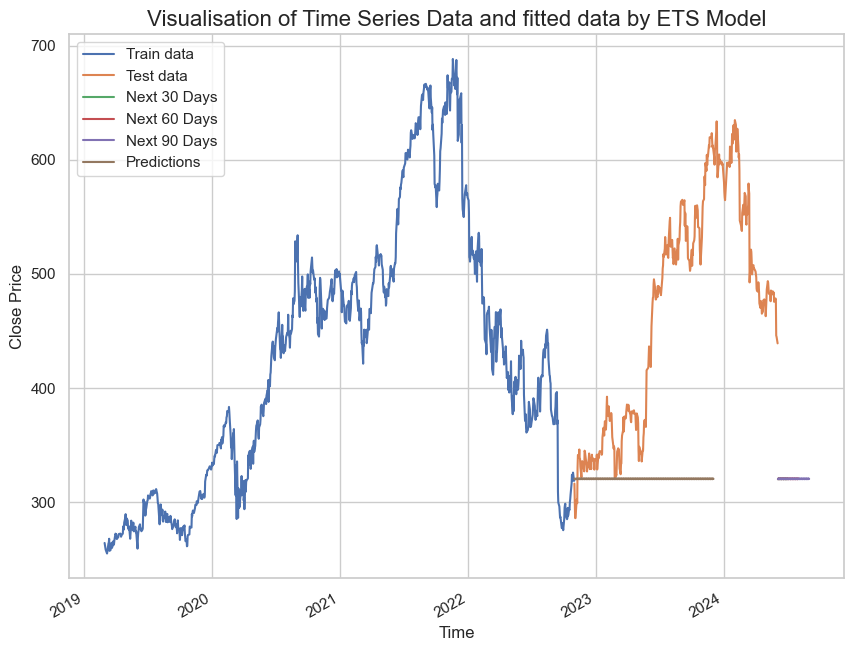

In [28]:
plt.figure(figsize=(10,8))
train_adbe_df1.plot(label='Train data')
test_adbe_df['close'].plot(label='Test data')
forecast_30_days.plot(label='Next 30 Days')
forecast_60_days.plot(label='Next 60 Days')
forecast_90_days.plot(label='Next 90 Days')
test_predictions.plot(label='Predictions')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Close Price");
plt.xlabel("Time")
plt.legend();